File name: main.ipynb

Author: ADAMsLEG

Date created: 03/11/2022

Date last modified: 03/11/2022

Python Version: 3.9


# Mental health during lockdowns through the eyes of Wikipedia
The Covid pandemic brought an undoubtedly change into our daily lives. Due to lockdowns, many people were forced to cut many of their social bounds, which we would expect had an impact on their mental health. As the basis of our analysis we use a time series dataset containing pageviews of selected Wikipedia articles in different languages related to mental health, hence we treat this research project as an observational study. Our first goal is to investigate if there was a change in pageviews of the selected Wikipedia articles during the covid lockdown period compared to the periods before and after. Secondly we will test if mobility had an impact on the readership of mental-health-related articles. We use mobility data from Apple and Google. Lastly, we compare the effects on mental health in different countries using the COVIDiSTRESS dataset. We aim to answer these questions by means of statistical analysis. In order to answer to do see, we need first to discover and understand the data we will handle. This is why we need to visualize the datasets.
## First approach with the datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import json

In [2]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"
TOPICS_LINKED_DATASET = DATA_PATH + "topics_linked.csv.xz"
AGGREGATED_JSON = DATA_PATH + "aggregated_timeseries.json.gz"
COVIDISTRESS_APRIL = DATA_PATH + "COVIDISTRESS_april_cleaned.csv"
COVIDISTRESS_MAI = DATA_PATH + "COVIDISTRESS_mai_cleaned.csv"
COVIDISTRESS_JUNE = DATA_PATH + "COVIDISTRESS_june_cleaned.csv"

### Wiki_pageviews_covid datasets

In [3]:
df_interventions = pd.read_csv(INTERVENTIONS_DATASET)
df_interventions.head()

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29


In [4]:
df_global = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip')
df_global.head()

C:\Users\josan\AppData\Local\Temp\ipykernel_33824\3108490629.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_global = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [5]:
df_topics = pd.read_csv(TOPICS_LINKED_DATASET, compression='xz')
df_topics.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q5465542


In [6]:
ts_aggregated = pd.read_json(AGGREGATED_JSON, compression='gzip')
ts_aggregated.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,"{'2018-01-01 00:00:00': 22328288, '2018-01-02 ...","{'2018-01-01 00:00:00': 3338750, '2018-01-02 0...","{'2018-01-01 00:00:00': 765123, '2018-01-02 00...","{'2018-01-01 00:00:00': 407629, '2018-01-02 00...","{'2018-01-01 00:00:00': 715031, '2018-01-02 00...","{'2018-01-01 00:00:00': 86763830, '2018-01-02 ...","{'2018-01-01 00:00:00': 192409, '2018-01-02 00...","{'2018-01-01 00:00:00': 493684, '2018-01-02 00...","{'2018-01-01 00:00:00': 135822131, '2018-01-02...","{'2018-01-01 00:00:00': 224417, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 1484496, '2018-01-02 0...","{'2018-01-01 00:00:00': 1319053, '2018-01-02 0...","{'2018-01-01 00:00:00': 451383, '2018-01-02 00...","{'2018-01-01 00:00:00': 7828155, '2018-01-02 0...","{'2018-01-01 00:00:00': 6441009, '2018-01-02 0...","{'2018-01-01 00:00:00': 523135, '2018-01-02 00...","{'2018-01-01 00:00:00': 111910, '2018-01-02 00...","{'2018-01-01 00:00:00': 12856884, '2018-01-02 ...","{'2018-01-01 00:00:00': 2383474, '2018-01-02 0...","{'2018-01-01 00:00:00': 819174, '2018-01-02 00..."
covid,"{'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...","{'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 57...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 91...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...",...,"{'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...","{'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...","{'len': 16, 'sum': {'2018-01-01 00:00:00': 62,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 2, '...","{'len': 49, 'sum': {'2018-01-01 00:00:00': 6, ...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 139...","{'len': 8, 'sum': {'2018-01-01 00:00:00': 19, ...","{'len': 113, 'sum': {'2018-01-01 00:00:00': 3,..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


In [7]:
df_anxiety_keyword = df_topics.loc[df_topics['index'].str.contains('anxiety').fillna(False)]
df_anxiety_keyword.head(5) #Social_anxiety is in the STEM.Medicine & Health topic,  

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
29745,Social_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q3557657
100264,Intergroup_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q6046586
637466,Preoperational_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q7240583
805017,Library_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q6542544
853325,Separation_anxiety_in_dogs,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q7451812


In [8]:
import gzip
data = [] #dict
with gzip.open(AGGREGATED_JSON, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))

STEM_medicineandhealth = data["en"]["topics"]["STEM.Medicine & Health"] #more example on how to use in dataset description excel doc
pd.DataFrame.from_dict(STEM_medicineandhealth)

,len,sum,percent
2018-01-01 00:00:00,63878,2207035,0.011472
2018-01-02 00:00:00,63878,3360222,0.012693
2018-01-03 00:00:00,63878,3648640,0.012824
2018-01-04 00:00:00,63878,3541603,0.013144
2018-01-05 00:00:00,63878,3357763,0.012822
...,...,...,...
2020-07-27 00:00:00,63878,2426547,0.011131
2020-07-28 00:00:00,63878,2442731,0.011610
2020-07-29 00:00:00,63878,2487592,0.012039
2020-07-30 00:00:00,63878,2297755,0.011380


### COVIDiSTRESS visualization
We will now visualize our subsets of interest from COVIDiSTRESS dataset.

In [9]:
df_covidistress_april = pd.read_csv(COVIDISTRESS_APRIL)
df_covidistress_april.head(3)

,Unnamed: 0.1,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,...,Expl_media_6,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg
0,0,1,1058,2020-04-27 04:20:30,DA,33,Female,"College degree, bachelor, master",Some College or equivalent,Full time employed,...,3.0,NaN,1.6,2.333333,2.000000,5.000000,4.666667,4.000000,3.666667,6.000000
1,1,2,1323,2020-04-27 04:17:16,NL,52,Male,"College degree, bachelor, master",Up to 12 years of school,Self-employed,...,4.0,Ik ben blij met de 'intelligente lockdown' zoa...,2.5,3.000000,4.666667,3.666667,5.000000,4.333333,4.666667,4.400000
2,2,3,801,2020-04-27 04:05:14,SK,52,Female,"College degree, bachelor, master",College degree,Full time employed,...,4.0,NaN,2.4,3.666667,3.000000,4.333333,4.333333,5.000000,4.666667,5.222222


In [10]:
df_covidistress_mai = pd.read_csv(COVIDISTRESS_MAI)
df_covidistress_mai.head(3)

C:\Users\josan\AppData\Local\Temp\ipykernel_33824\1816487094.py:1: DtypeWarning: Columns (56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covidistress_mai = pd.read_csv(COVIDISTRESS_MAI)


,Unnamed: 0,ID,answered_all,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
0,3,4,No,1710,2020-05-29 22:47:17,BG,79,Male,"College degree, bachelor, master",College degree,...,NaN,3.6,4.000000,4.000000,4.666667,4.000000,5.000000,5.000000,3.9,NaN
1,5,6,Yes,1221,2020-05-29 21:25:09,IT,68,Male,"College degree, bachelor, master",College degree,...,NaN,2.1,2.333333,3.333333,3.666667,4.333333,4.000000,3.666667,5.0,NaN
2,22,23,Yes,1004,2020-05-29 18:03:27,FR,28,Female,PhD/Doctorate,Up to 9 years of school,...,NaN,2.8,2.333333,4.666667,4.000000,5.333333,4.666667,3.333333,5.0,NaN


In [11]:
df_covidistress_june = pd.read_csv(COVIDISTRESS_JUNE)
df_covidistress_june.head(3)

C:\Users\josan\AppData\Local\Temp\ipykernel_33824\883657938.py:1: DtypeWarning: Columns (55,56,57,58,59,60,61,66,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covidistress_june = pd.read_csv(COVIDISTRESS_JUNE)


,Unnamed: 0.1,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
0,0,1,777,2020-06-17 01:01:39,NL,48,Female,"College degree, bachelor, master",NaN,Full time employed,...,Reguliere ziekenhuiszorg is verminderd: mijn c...,2.4,2.666667,4.000000,3.666667,4.666667,4.333333,5.000000,5.1,NaN
1,1,2,952,2020-06-16 23:19:18,PL,36,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,...,NaN,1.7,1.000000,2.333333,3.666667,3.000000,3.666667,4.666667,5.3,NaN
2,2,3,2396,2020-06-16 22:47:36,EN,45,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,...,NaN,1.7,2.000000,2.666667,4.333333,5.000000,5.000000,5.000000,5.2,NaN


We will now visualize the data which interest us, which are the average perceived stress (PSS10_avg) and the average perceived loneliness (SLON3_avg) accross the month of April to June in Italie, Poland, the Netherlands and Sweden.

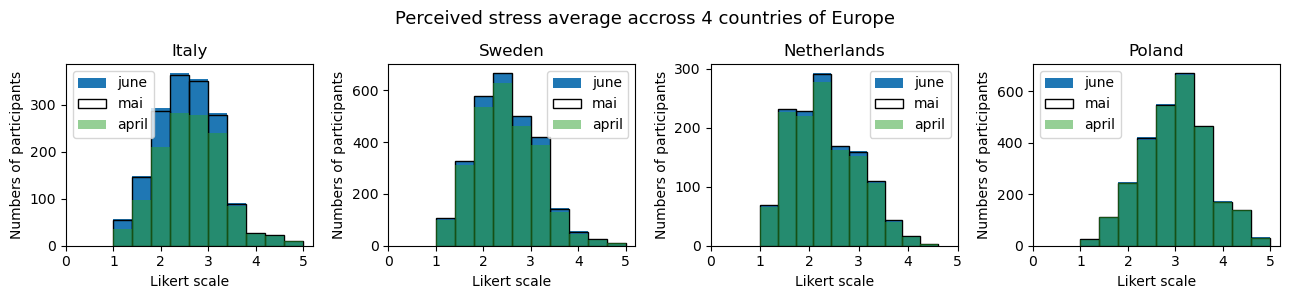

In [12]:
#list of months to choose data set
MONTHS = ['june', 'mai', 'april']
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']
#april_country = df_covidistress_april.groupby(['Country']).size()

fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()
for country, axe in zip(COUNTRIES_INTEREST, axes):
    df_hist_june = df_covidistress_june.loc[df_covidistress_june['Country'] == country]
    df_hist_mai = df_covidistress_mai.loc[df_covidistress_mai['Country'] == country]
    df_hist_april = df_covidistress_april.loc[df_covidistress_april['Country'] == country]
    
    axe.hist(df_hist_june['PSS10_avg'][:])
    axe.hist(df_hist_mai['PSS10_avg'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['PSS10_avg'][:], alpha = .5)
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived stress average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)

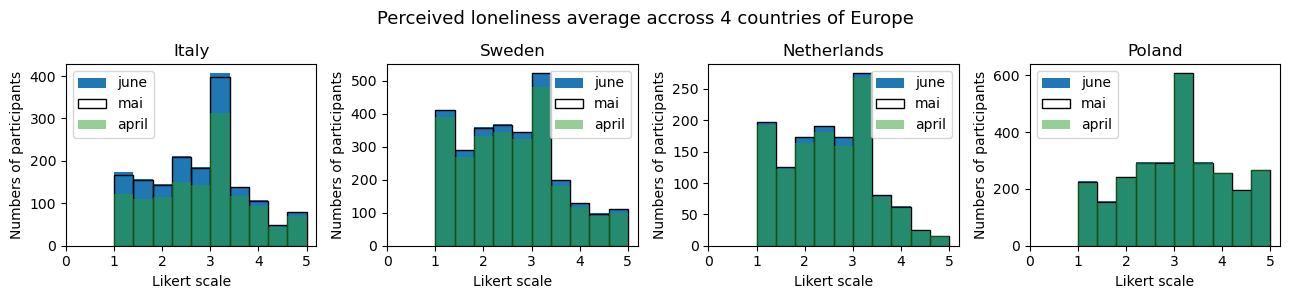

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()
for country, axe in zip(COUNTRIES_INTEREST, axes):
    df_hist_june = df_covidistress_june.loc[df_covidistress_june['Country'] == country]
    df_hist_mai = df_covidistress_mai.loc[df_covidistress_mai['Country'] == country]
    df_hist_april = df_covidistress_april.loc[df_covidistress_april['Country'] == country]
    
    axe.hist(df_hist_june['SLON3_avg'][:])
    axe.hist(df_hist_mai['SLON3_avg'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['SLON3_avg'][:], alpha = .5)
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived loneliness average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)

## Dataset: Wikipedia:Pageview statistics

As we said in the Read.me, in order to analyze mental health awareness during lockdowns of Covid19, we decided to consider 5 mental disorders: anxiety, depression, loneliness, insomnia and physiological stress. For each of these diseases, we will use the number of Wikipedia page views about these diseases in the period 2019-01-01 - 2022-09-01. All data was downloaded from the website Wikipedia:Pageview statistics (https://pageviews.wmcloud.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&range=latest-20&pages=).

Let's see what the data looks like (only first few dates)

In [2]:
with open('{}.json'.format('./data/anxiety_en'), 'r') as file:
    data = json.load(file)[0]

print('First few dates')    
dict(list(data.items())[0: 10]) 

First few dates


{'page': 'Anxiety disorder',
 'sum': 1991316,
 'daily_average': 1454,
 '2019-01-01': 1486,
 '2019-01-02': 1842,
 '2019-01-03': 1715,
 '2019-01-04': 1724,
 '2019-01-05': 1872,
 '2019-01-06': 1771,
 '2019-01-07': 1968}

We have the page name, the total number of page views for the selected period, the average number of views per day and the number of page views for each day of the period. Let's make one table for all data in which there will be 6 columns: 

[PageName, Date, PageViews, Month, Year ,Month/Year]

Fortunately, there are no missing values in this dataset, but there are some outliers. To cope with these outliers, we will use an interquartile range approach. Define as 

Q1 = PageViews.quantile(0.25), Q3 = PageViews.quantile(0.75), IQR = Q3 - Q1.
We will delete all values that are not in range:

[Q1 - 1.5 * IQR; Q3 + 1.5 * IQR]

In [5]:
diseases_names = ['anxiety_en', 'depression_en', 'insomnia_en', 'loneliness_en', 'stress_en']

def get_data():
    # create DataFrame
    df = pd.DataFrame({'PageName' :[], 'Date':[], 'PageViews':[]}) 
    for disease in diseases_names:
        # read files
        with open('./data/{}.json'.format(disease), 'r') as file: 
            data = json.load(file)[0]
            # convert string to date type
            date = pd.to_datetime(list(data.keys())[3:])
            # add data to DataFrame
            df = pd.concat([df, pd.DataFrame({'PageName' :[disease]*(len(data)-3), 'Date':date.date, 
                                              'Month':list(map(lambda x: x[5:7], list(data.keys())[3:])),
                                              'Year':list(map(lambda x: x[:4], list(data.keys())[3:])), 
                                              'Day':list(map(lambda x: x[8:], list(data.keys())[3:])),
                                              'Month/Year': list(date.strftime('%m/%Y')), 
                                              'PageViews':list(data.values())[3:]})])
    
    
    # interquartile range approach for deleting outliers
    Q1 = df['PageViews'].quantile(0.25)
    Q3 = df['PageViews'].quantile(0.75)
    IQR = Q3 - Q1    

    df = df[(df['PageViews'] >= Q1 - 1.5 * IQR) & (df['PageViews'] <= Q3 + 1.5 *IQR)] 
    
    return df

In [6]:
df = get_data()
df.head()

,PageName,Date,PageViews,Month,Year,Day,Month/Year
0,anxiety_en,2019-01-01,1486.0,01,2019,01,01/2019
1,anxiety_en,2019-01-02,1842.0,01,2019,02,01/2019
2,anxiety_en,2019-01-03,1715.0,01,2019,03,01/2019
3,anxiety_en,2019-01-04,1724.0,01,2019,04,01/2019
4,anxiety_en,2019-01-05,1872.0,01,2019,05,01/2019


In [9]:
from datetime import datetime

# A function for plotting boxplots of page views by month for a given page and period [start_date, end_date]

def plot_monthly_stats(df, page_name, start_date, end_date, show_outliers=False):
    sns.set(rc={'figure.figsize':(12,8)})
    plt.title('Monthly boxplots of page views for {} from {} to {}'.format(page_name, start_date, end_date))
    
    #consider only data in period [start_date, end_date]
    data = df[(df['Date'] >= datetime.strptime(start_date, '%Y-%m-%d').date())  &  
              (df['Date'] <= datetime.strptime(end_date, '%Y-%m-%d').date())]

    # plot boxplot    
    ax = sns.boxplot(x='Month/Year', y="PageViews", data=data,
                        showmeans=True, showfliers=show_outliers)
    # plot average of pageviews by month 
    ax = sns.pointplot(x='Month/Year', y="PageViews", data=data,
                       errorbar=None, color='black')
    # Put the date on the x axis vertically 
    ax.tick_params(axis='x', labelrotation=90)

Let's plot the distribution of page views on the topic "Depression" during 2020.

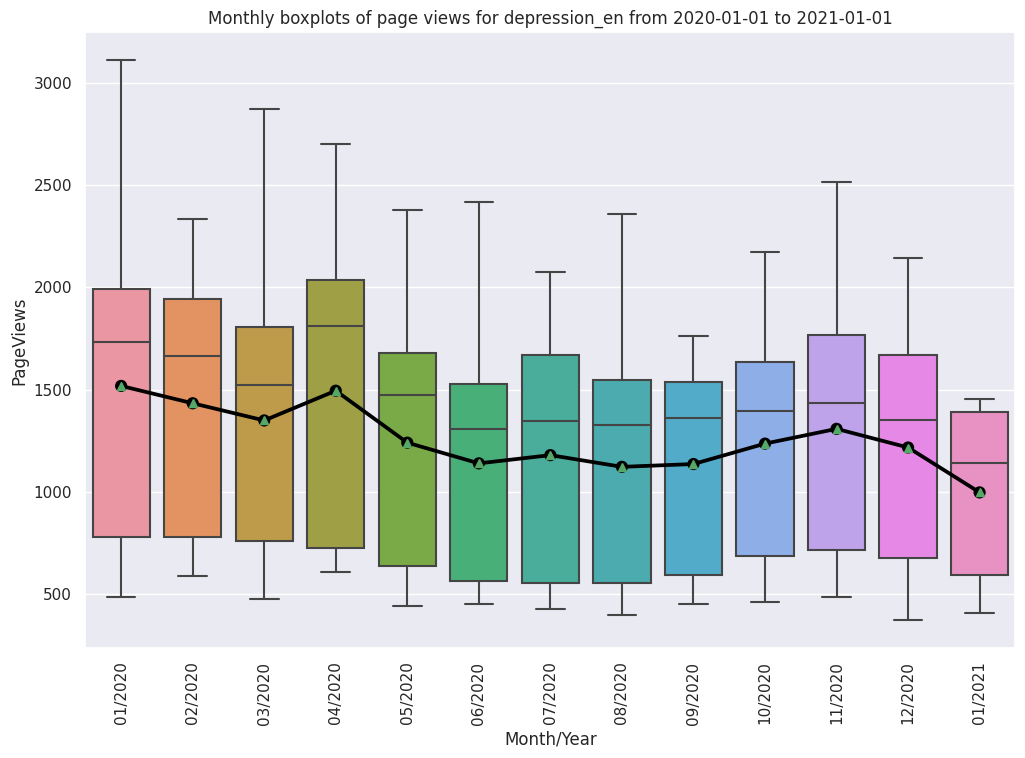

In [10]:
plot_monthly_stats(df, page_name='depression_en', start_date='2020-01-01', end_date='2021-01-01', show_outliers=True)

In [11]:
#A function for plotting the average number of pageviews by month for all disorders for a given period
# [start_date, end_date]

def plot_compare_disorders(df, start_date, end_date, errorbar='sd'):
    data = df[(df['Date'] >= datetime.strptime(start_date, '%Y-%m-%d').date())  &  
              (df['Date'] <= datetime.strptime(end_date, '%Y-%m-%d').date())]
    
    plt.title('Monthly average number of pageviews for each disorders from {} to {} by topics'.format(start_date, end_date))
    ax = sns.lineplot(x="Month/Year", y="PageViews", data=data, errorbar=errorbar, hue="PageName")
    ax.tick_params(axis='x', labelrotation=90)

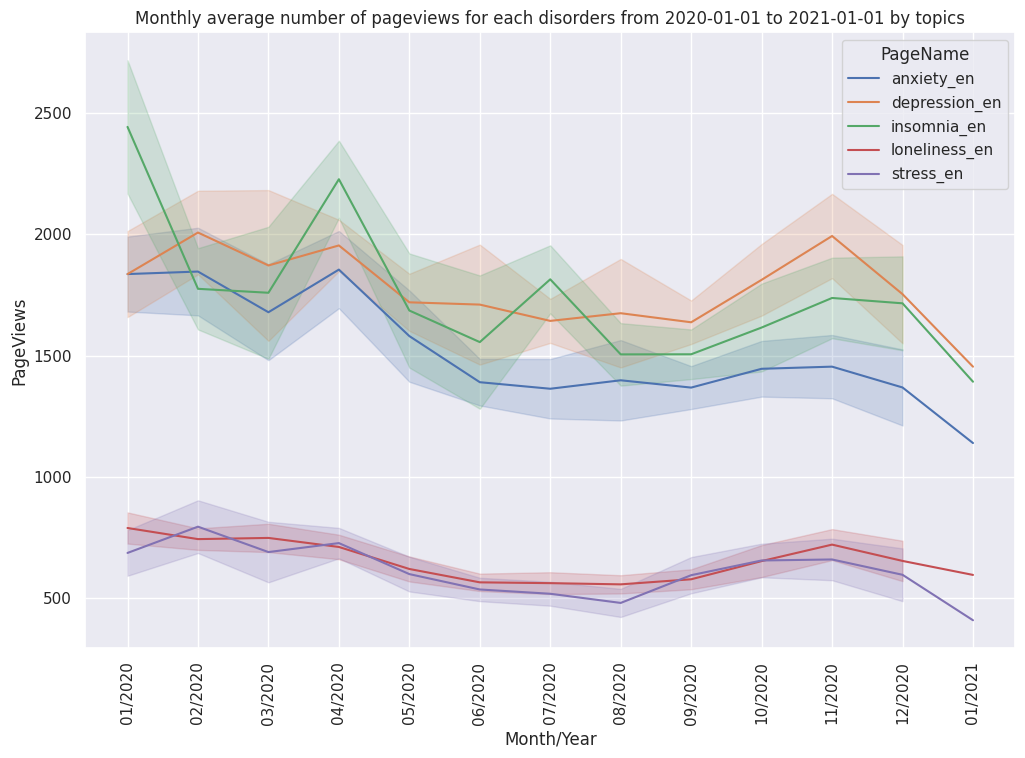

In [12]:
plot_compare_disorders(df, start_date='2020-01-01', end_date='2021-01-01')

In [13]:
# A function for plotting the average monthly number of page views about a given disorder by year

def plot_compare_disprder_by_years(df, page_name='depression_en', errorbar='sd'):
    plt.title('Monthly average number of pageviews about {} by years'.format(page_name))
    ax = sns.lineplot(x="Month", y="PageViews", data=df[df['PageName'] == page_name], errorbar=errorbar, hue="Year")

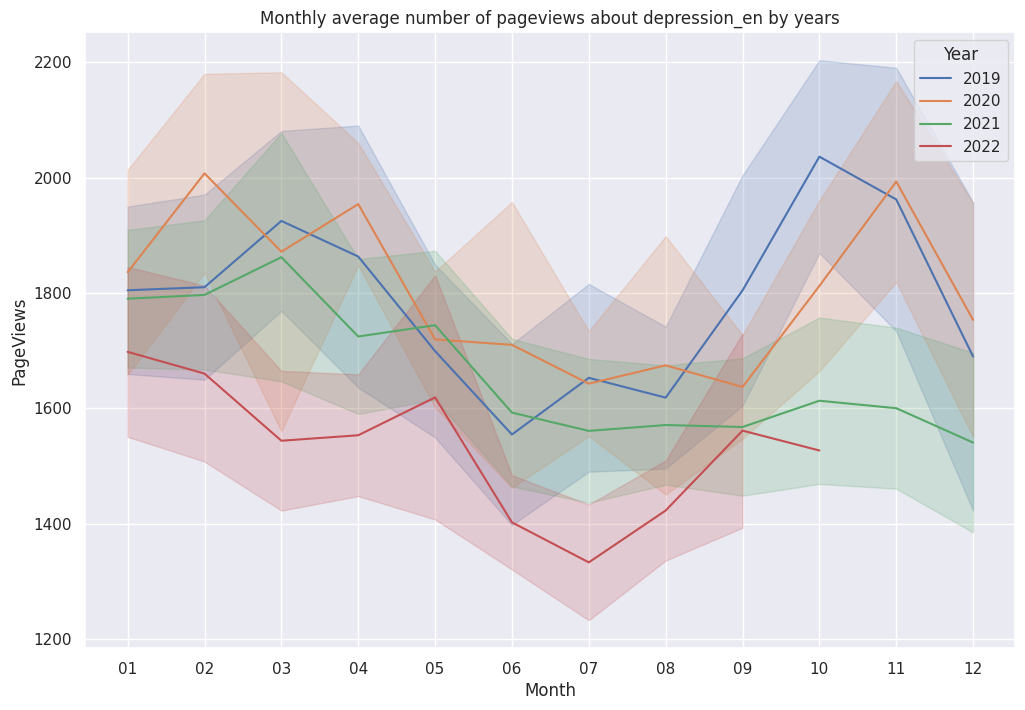

In [14]:
plot_compare_disprder_by_years(df, page_name='depression_en')

Let's do a t-test in which we compare the average number of views of the Wikipedia page about depression in 2020 and in 2021. Let's check whether their average differs statistically significantly and if so, we will try to understand in which direction.

In [15]:
def cohen_d(sample_A, sample_B):
    '''
     Compute cohen's d value for independent values
     :param sample_A and sample_B: pd.DataFrame
     :return: d
     '''
    diff_mean = np.abs(np.mean(sample_A) - np.mean(sample_B))
    nb_A = len(sample_A)
    nb_B = len(sample_B)
    A_sd = np.std(sample_A)
    B_sd = np.std(sample_B)
    
    pooled_sd = np.sqrt(((nb_A-1) * A_sd**2 + (nb_B-1) * B_sd**2)/(nb_A + nb_B -2))
    
    d = diff_mean/pooled_sd
    
    print('Cohen s d effect size value is d = ' + str(d) 
      + ' with the sample size n = ' + str(len(sample_A)))
    
    return d

# Function for conducting T-test.

def test_pageviews_means(page_name):
    # Take pageviews statistics  
    depression_2020 = df[(df['Year'] == '2020') & (df['PageName'] == page_name)]['PageViews'].to_list()
    depression_2021 = df[(df['Year'] == '2021') & (df['PageName'] == page_name)]['PageViews'].to_list()

    # Find mean for each year
    mean_2020 = np.mean(depression_2020)
    mean_2021 = np.mean(depression_2021)
    
    # T-tes. Assume that variance doesn't change
    tvalue2, pvalue2 = stats.ttest_ind(depression_2020, depression_2021, equal_var= True)
    
    print('Pvalue of the sample t-test for the pageviews statistic about {} in 2020 and 2021:\n {}\n'.format(page_name, pvalue2))
    cohen_d(depression_2020, depression_2021)
    print('\nPageviews mean for 2020 and 2021 and their difference: \n  {}, {}, {}'.format(mean_2020, mean_2021, mean_2020-mean_2021))

In [16]:
test_pageviews_means('depression_en')

Pvalue of the sample t-test for the pageviews statistic about depression_en in 2020 and 2021:
 1.8919218606161319e-19

Cohen s d effect size value is d = 0.6894364266588466 with the sample size n = 362

Pageviews mean for 2020 and 2021 and their difference: 
  1799.7845303867402, 1663.0438356164384, 136.74069477030184


It is clear from the test results that p_value < 0.05 and  the Cohen's effect is large, so we can reject the hypothesis that they have the same average value. Also we can notice  that on average in 2020 the number of views of the Wikipedia page about depression is greater than in 2021. This gives us some confidence that we can actually see changes in awareness of mental health problems during covid.